### Step 1: Load data

In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve
from skmultilearn.model_selection import IterativeStratification
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm import tqdm

from ChestXRayDataset import ChestXRayDataset

In [2]:
df_train = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_train.csv')
df_val = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_val.csv')
df_test = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_test.csv')

In [3]:
df_train.shape, df_val.shape, df_test.shape

((78506, 22), (12533, 22), (21081, 22))

In [4]:
# Count classes to determinate majority classes
class_counts = df_train.iloc[:, 1:-2].sum(axis=0)
class_counts

Atelectasis                    7587
Cardiomegaly                   1590
Consolidation                  2626
Edema                          1283
Effusion                       7919
Emphysema                      1327
Fibrosis                       1138
Hernia                          130
Infiltration                  12739
Mass                           3689
Nodule                         4359
Pleural Thickening             1998
Pneumonia                       806
Pneumothorax                   2432
Pneumoperitoneum                214
Pneumomediastinum                88
Subcutaneous Emphysema          957
Tortuous Aorta                  598
Calcification of the Aorta      368
dtype: int64

Some images exist in images folder, but not in miccai labels and opposite

To fix this problem We create list of all image IDs in both train and test _images folder
then ensure that only images withing this list are loaded to dataset

In [5]:
image_dir_train = '../data/train_images'
image_dir_test = '../data/test_images'
# Define function to get valid image ids that exist in the image directory
def get_valid_image_ids(df, image_dir):
    # Get the set of image IDs that exist in the image directory
    image_files = set(os.listdir(image_dir))  # List of all files in the image directory
    # Check if image id exists in the image directory
    valid_ids = df[df['id'].isin(image_files)]['id']
    return valid_ids

In [6]:
# Get valid image ids for train and test datasets
valid_train_ids = get_valid_image_ids(df_train, image_dir_train)
valid_val_ids = get_valid_image_ids(df_val, image_dir_train)
valid_test_ids = get_valid_image_ids(df_test, image_dir_test)

In [7]:
# Filter the DataFrames to include only the valid image IDs
df_train_valid = df_train[df_train['id'].isin(valid_train_ids)]
df_val_valid = df_val[df_val['id'].isin(valid_val_ids)]
df_test_valid = df_test[df_test['id'].isin(valid_test_ids)]

df_train_valid.shape, df_val_valid.shape, df_test_valid.shape

((78506, 22), (8018, 22), (21081, 22))

In [8]:
df_train_val = pd.concat([df_train_valid, df_val_valid], ignore_index=True)
assert df_train_val.shape[0] == df_train_valid.shape[0] + df_val_valid.shape[0]

In [9]:
df_train_val.drop(df_train_val[df_train_val['No Finding'] == 1].index, inplace=True)
df_test_valid.drop(df_test_valid[df_test_valid['No Finding'] == 1].index, inplace=True)
df_train_val.shape, df_test_valid.shape

((36778, 22), (13066, 22))

In [10]:
df_train_val = df_train_val.copy()
# Drop No Finding also since model A is looking at it
df_train_val.drop(columns=['subj_id', 'No Finding'], inplace=True)
df_train_val.shape

(36778, 20)

In [11]:
## Do same for testing
df_test_valid = df_test_valid.copy()
df_test_valid.drop(columns=['subj_id', 'No Finding'], inplace=True)
df_test_valid.shape

(13066, 20)

### Create minority column

Identify rows where any column not in majority_classes has a value of 1, and assign 1 to the minority column; otherwise, 0.

***Step 1: Identify majority classes***

In [12]:
# Count classes to determinate majority classes
class_counts = df_train_val.iloc[:, 1:].sum(axis=0)
class_counts

Atelectasis                    8280
Cardiomegaly                   1707
Consolidation                  2852
Edema                          1378
Effusion                       8659
Emphysema                      1423
Fibrosis                       1251
Hernia                          141
Infiltration                  13782
Mass                           4034
Nodule                         4708
Pleural Thickening             2242
Pneumonia                       876
Pneumothorax                   2637
Pneumoperitoneum                231
Pneumomediastinum                92
Subcutaneous Emphysema         1023
Tortuous Aorta                  634
Calcification of the Aorta      395
dtype: int64

In [13]:
majority_threshold = 3000
majority_classes = class_counts[class_counts > majority_threshold].index.tolist()
majority_classes

['Atelectasis', 'Effusion', 'Infiltration', 'Mass', 'Nodule']

***Step 2: create 'minority' column***

In [14]:
def is_minority(row):
    # Check if any category outside majority_classes has a value of 1
    for col in row.index:
        if col not in ['id'] + majority_classes and row[col] == 1: # check values for categories that not in majority and 'id'
            return 1
    return 0

In [15]:
df_train_val['minority'] = df_train_val.apply(is_minority, axis=1)
df_test_valid['minority'] = df_test_valid.apply(is_minority, axis=1)

In [16]:
df_train_val.head()

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Nodule,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,minority
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,00000004_000.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
11,00000005_006.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


***Step 3: Drop columns that have been grouped to 'minority'***

In [17]:
columns_to_keep = ['id'] + majority_classes + ['minority']
df_train_val = df_train_val[columns_to_keep]
df_test_valid = df_test_valid[columns_to_keep]

In [18]:
df_train_val.shape, df_test_valid.shape

((36778, 7), (13066, 7))

In [20]:
df_train_val.sample(2)

,id,Atelectasis,Effusion,Infiltration,Mass,Nodule,minority
27169,00008904_000.png,1,0,0,0,0,0
30006,00009940_004.png,0,0,1,0,0,1


### Create 'finding' and 'finding_encoded' columns

#### Step 2.1: create mappings variable for all categories we have

In [21]:
# Extract all categories (exclude 'id')
categories = df_train_val.columns[1:]

# Create a mapping dictionary for categories to numbers
category_mapping = {category: idx for idx, category in enumerate(categories)}

print("Category Mapping:")
print(category_mapping)

Category Mapping:
{'Atelectasis': 0, 'Effusion': 1, 'Infiltration': 2, 'Mass': 3, 'Nodule': 4, 'minority': 5}


### Step 2.3: Create finding column

This column will contain list of all finding categories for each image, and we have the following scenarios
1. The image has no sickness ==> finding column is a list with only one item 'No Finding'
2. The image contains only one category i.g 'Hernia' ==> finding column is a list with only one item 'Hernia'
3. The image contains more than one category i.g 'Hernia' and 'Edema'...etc. ==> finding column is a list finding items 'Hernia' and 'Edema'

In [22]:
# Function to create 'finding' and 'finding_encoded' as a string based on category values
def create_finding(row):
    # Generate lists of findings and their encoded values
    findings = [category for category in categories if row[category] == 1]
    encoded_findings = [str(category_mapping[category]) for category in findings]
    
    # Join encoded findings as a single string for stratification
    return findings, ','.join(encoded_findings)


In [23]:
# Apply function to create 'finding' and 'finding_encoded' columns in train_val data
df_train_val[['finding', 'finding_encoded']] = df_train_val.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

df_train_val[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
0,00000001_000.png,[minority],5
1,00000001_001.png,[minority],5
2,00000001_002.png,"[Effusion, minority]","1,5"
4,00000004_000.png,"[Mass, Nodule]","3,4"
11,00000005_006.png,[Infiltration],2
...,...,...,...
86519,00030601_000.png,[Atelectasis],0
86520,00030661_000.png,[Atelectasis],0
86521,00030703_000.png,[Nodule],4
86522,00030703_001.png,[Nodule],4


In [24]:
# Apply function to create 'finding' and 'finding_encoded' columns in test data
df_test_valid[['finding', 'finding_encoded']] = df_test_valid.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

df_test_valid[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
1,00000013_001.png,[minority],5
2,00000013_002.png,[minority],5
3,00000013_003.png,[minority],5
4,00000013_004.png,"[Effusion, Infiltration, minority]","1,2,5"
5,00000013_005.png,"[Infiltration, minority]","2,5"
...,...,...,...
20972,00030637_023.png,[Infiltration],2
20999,00030674_000.png,"[Atelectasis, minority]","0,5"
21001,00030677_000.png,[minority],5
21016,00030692_000.png,[Atelectasis],0


### Step 3: Create subsets and DataLoaders for the training, validation, and test sets

In [25]:
# Image transformation for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
train_val_ratio = 0.8 # For train, val ratio

#### Create dataset's and dataloader's

**First: create the subset**

In [27]:
# Perform the stratified split
label_matrix = df_train_val['finding_encoded'].str.get_dummies(sep=',')
stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[train_val_ratio, 1 - train_val_ratio]) 
val_indices, train_indices = next(stratifier.split(df_train_val, label_matrix))

train_df = df_train_val.iloc[train_indices].reset_index(drop=True)
val_df = df_train_val.iloc[val_indices].reset_index(drop=True)

# Verify the sizes
print(f"Train size (80% of subset): {len(train_df)} rows")
print(f"Val size (20% of subset): {len(val_df)} rows")

Train size (80% of subset): 29221 rows
Val size (20% of subset): 7557 rows


In [29]:
assert df_train_val.shape[0] == train_df.shape[0]+ val_df.shape[0]

#### Step 3.2: Create dataset objects


In [28]:
train_dataset = ChestXRayDataset(dataframe=train_df, image_dir=image_dir_train, category_mapping=category_mapping, transform=train_transform)

val_dataset = ChestXRayDataset(dataframe=val_df, image_dir=image_dir_train, category_mapping=category_mapping, transform=val_transform)

test_dataset = ChestXRayDataset(dataframe=df_test_valid, image_dir=image_dir_test, category_mapping=category_mapping, transform=val_transform)

#### Step 3.3: Create dataloaders

In [29]:
# Create Dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [30]:
print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Testing DataLoader: {len(test_loader)} batches")

Training DataLoader: 914 batches
Validation DataLoader: 237 batches
Testing DataLoader: 409 batches


In [31]:
img, label, img_id = train_dataset[100]
print(f"Image ID: {img_id}")
print(f"Label: {label}")
print(f"Image Shape: {img.shape}")

Image ID: 00000138_006.png
Label: tensor([0., 0., 0., 0., 0., 1.])
Image Shape: torch.Size([3, 224, 224])


In [32]:
train_df[train_df.id == img_id]

,id,Atelectasis,Effusion,Infiltration,Mass,Nodule,minority,finding,finding_encoded
100,00000138_006.png,0,0,0,0,0,1,[minority],5


### Step 4: Define the model
We use pretrained ResNet
- We add linear layer to predict multi-label ( more than one category per image)
- ResNet-50 designed to output 2048 features
- We add two Linear layer to avoid going down from 2048 features to only 20 which may cause instability and overfitting

**Note**: Different additional params/functionality to the network i.g Dropout, normalization...etc. have been tested

In [33]:
# Number of unique categories (labels) in the 'finding_encoded' column
num_classes = len(df_train_val['finding_encoded'].str.get_dummies(sep=',').columns)
print(num_classes)

6


In [34]:
model = models.resnet152(weights='IMAGENET1K_V2') # Different ResNet has been tested
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(), 
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(), 
    nn.Dropout(0.2),
    nn.Linear(256, num_classes), # 6 different classes ( 5 + minority)
    nn.Sigmoid()  # Sigmoid for multi-label classification
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


### Step 5: Train, Validate and test the model

[Referance about BCEWithLogitsLoss()](https://medium.com/@sahilcarterr/why-nn-bcewithlogitsloss-numerically-stable-6a04f3052967)

nn.BCEWithLogitsLoss():

1. This loss function is more efficient because it combines the sigmoid activation and binary cross-entropy loss into a single function.
2. It expects the raw logits (not passed through sigmoid) as input and applies the sigmoid internally.
3. It's numerically more stable and faster than using nn.BCELoss() with a separate sigmoid.

nn.BCELoss():

1. This loss function expects the model's output to be probabilities in the range [0, 1], so it requires you to apply a sigmoid activation to the model's output beforehand.
2. The formula for binary cross-entropy is applied after transforming the raw logits into probabilities using the sigmoid function.

***Define weighted classes***

In [35]:
categories  = train_df['finding_encoded'].str.split(',').explode().value_counts()
categories.index = categories.index.astype(int)
categories = categories.sort_index()
categories

finding_encoded
0     6624
1     6927
2    11026
3     3227
4     3766
5    11191
Name: count, dtype: int64

In [36]:
total = len(train_df)
total

29221

In [37]:
proportions =  categories / total
proportions

finding_encoded
0    0.226686
1    0.237056
2    0.377331
3    0.110434
4    0.128880
5    0.382978
Name: count, dtype: float64

In [38]:
weights = 1 / proportions
weights

finding_encoded
0    4.411383
1    4.218421
2    2.650190
3    9.055160
4    7.759161
5    2.611116
Name: count, dtype: float64

In [39]:
normalized_weights = weights / weights.sum()
normalized_weights

finding_encoded
0    0.143668
1    0.137384
2    0.086310
3    0.294904
4    0.252697
5    0.085038
Name: count, dtype: float64

In [40]:
weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
weights_tensor

tensor([4.4114, 4.2184, 2.6502, 9.0552, 7.7592, 2.6111], device='cuda:0')

In [41]:
# Use BCEWithLogitsLoss for multi-label classification
criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor) 

In [43]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) 

In [44]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-7)
#lookahead_optimizer = optim_mod.Lookahead(optimizer, k=5, alpha=0.5)

#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.7)

In [45]:
# Initialize lists to store loss and accuracy per epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [46]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels, _ in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.float())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Class-specific threshold selection based on F1 score
    thresholds = []
    for i in range(all_labels.shape[1]):  # Iterate through each class
        precision, recall, threshold = precision_recall_curve(all_labels[:, i], all_preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8) # 1e-8 To fix/avoid dividing by zero problem
        best_threshold = threshold[np.argmax(f1_scores)]
        thresholds.append(best_threshold)

    final_preds = np.zeros_like(all_preds)
    for i, threshold in enumerate(thresholds):
        final_preds[:, i] = (all_preds[:, i] > threshold).astype(float)

    correct_predictions = (final_preds == all_labels).all(axis=1).sum()
    total_predictions = all_preds.shape[0]

    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / total_predictions) * 100

    report = classification_report(all_labels, final_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)

    return avg_loss, avg_accuracy, precision, recall, f1, thresholds, correct_predictions

In [47]:
def validate(model, dataloader, criterion, device, thresholds):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    final_preds = np.zeros_like(all_preds)
    for i, threshold in enumerate(thresholds):
        final_preds[:, i] = (all_preds[:, i] > threshold).astype(float)

    correct_predictions = (final_preds == all_labels).all(axis=1).sum()
    total_predictions = all_preds.shape[0]

    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / total_predictions) * 100

    report = classification_report(all_labels, final_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    val_losses.append(avg_loss)
    val_accuracies.append(avg_accuracy)

    return avg_loss, avg_accuracy, precision, recall, f1, correct_predictions

In [48]:
def test(model, dataloader, criterion, device, label_names, best_thresholds):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Dynamic threshold for each label based on train data
    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    print("\nFinding Best Thresholds for Each Class (Reported Only):")
    for i, threshold in enumerate(best_thresholds):
        print(f"Class '{label_names[i]}': Best Threshold = {threshold:.4f}")

    default_preds = (all_preds > 0.5).astype(float)

    print("\nClassification Report with Best Thresholds:")
    report_best = classification_report(all_labels, thresholded_preds, target_names=label_names, zero_division=0)
    print(report_best)

    print("\nClassification Report with Default Threshold (0.5):")
    report_default = classification_report(all_labels, default_preds, target_names=label_names, zero_division=0)
    print(report_default)

    avg_loss = running_loss / len(dataloader)

    return avg_loss, report_best, report_default, best_thresholds

In [49]:
num_epochs = 100

# Early stopping parameters
patience = 7 # wait 
best_val = 0
epochs_no_improve = 0

# for plotting
num_epochs_runned = 0

In [51]:
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    # Train the model for one epoch
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_best_threshold, train_correct_predictions = train(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
      f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
      f"Train F1: {train_f1:.4f}, Train Best Threshold: {train_best_threshold}, "
      f"Train correct predictions: {train_correct_predictions}")



    # Validate the model after training
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_correct_predictions = validate(model, val_loader, criterion, device, train_best_threshold)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
      f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, "
      f"Val F1: {val_f1:.4f}, Val correct predictions: {val_correct_predictions}")


    # Step the Lookahead optimizer
    #lookahead_optimizer.step()
    # Step the ReduceLROnPlateau scheduler
    #scheduler.step(val_loss)
    
    scheduler.step()

    print(f"Epoch {epoch + 1}: Learning rate = {scheduler.get_last_lr()[0]}")

    num_epochs_runned += 1

    # Validation loss has improved
    if val_f1 > best_val:
        best_val = val_f1
        epochs_no_improve = 0  # Reset the counter if we see improvement
        
        # Save the model checkpoint
        torch.save(model.state_dict(), "best_model_b_last.pth")
        print("Model improved and saved.")
    else:
        print("Model did not improved")
        epochs_no_improve += 1  # Increment counter if no improvement

    # Early stopping
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break

    print("-" * 150)

Epoch [1/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.1904, Train Accuracy: 0.0821, Train Precision: 0.2502, Train Recall: 0.9155, Train F1: 0.3831, Train Best Threshold: [0.5154255, 0.51903933, 0.50021094, 0.50025517, 0.51462847, 0.5001631], Train correct predictions: 24


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.44it/s]


Val Loss: 1.1716, Val Accuracy: 0.0662, Val Precision: 0.2529, Val Recall: 0.8717, Val F1: 0.3817, Val correct predictions: 5
Epoch 1: Learning rate = 0.001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [2/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.31it/s]


Train Loss: 1.1825, Train Accuracy: 0.4688, Train Precision: 0.2682, Train Recall: 0.7994, Train F1: 0.3945, Train Best Threshold: [0.5162664, 0.5413314, 0.5059192, 0.5081124, 0.52226084, 0.50015575], Train correct predictions: 137


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.53it/s]


Val Loss: 1.1697, Val Accuracy: 0.4896, Val Precision: 0.2579, Val Recall: 0.8270, Val F1: 0.3869, Val correct predictions: 37
Epoch 2: Learning rate = 0.001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [3/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.31it/s]


Train Loss: 1.1777, Train Accuracy: 0.2772, Train Precision: 0.2717, Train Recall: 0.8312, Train F1: 0.4003, Train Best Threshold: [0.513867, 0.52699226, 0.5003735, 0.50291216, 0.5107833, 0.5015761], Train correct predictions: 81


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.44it/s]


Val Loss: 1.1672, Val Accuracy: 0.1720, Val Precision: 0.2626, Val Recall: 0.8453, Val F1: 0.3900, Val correct predictions: 13
Epoch 3: Learning rate = 0.001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [4/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.31it/s]


Train Loss: 1.1748, Train Accuracy: 0.4312, Train Precision: 0.2732, Train Recall: 0.7994, Train F1: 0.4012, Train Best Threshold: [0.5130247, 0.51340216, 0.5065358, 0.50684345, 0.51646817, 0.50572133], Train correct predictions: 126


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.53it/s]


Val Loss: 1.1657, Val Accuracy: 0.2514, Val Precision: 0.2652, Val Recall: 0.8055, Val F1: 0.3863, Val correct predictions: 19
Epoch 4: Learning rate = 0.001
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [5/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.30it/s]


Train Loss: 1.1718, Train Accuracy: 0.5168, Train Precision: 0.2803, Train Recall: 0.7860, Train F1: 0.4058, Train Best Threshold: [0.5139115, 0.5299261, 0.5091588, 0.50828713, 0.52174675, 0.5307422], Train correct predictions: 151


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.49it/s]


Val Loss: 1.1695, Val Accuracy: 0.2117, Val Precision: 0.2686, Val Recall: 0.8015, Val F1: 0.3886, Val correct predictions: 16
Epoch 5: Learning rate = 0.0009000000000000001
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [6/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.1680, Train Accuracy: 0.6844, Train Precision: 0.2862, Train Recall: 0.7543, Train F1: 0.4088, Train Best Threshold: [0.52379316, 0.56363744, 0.5045516, 0.52170837, 0.5161448, 0.5236203], Train correct predictions: 200


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.50it/s]


Val Loss: 1.1633, Val Accuracy: 0.5690, Val Precision: 0.2839, Val Recall: 0.7266, Val F1: 0.3834, Val correct predictions: 43
Epoch 6: Learning rate = 0.0009000000000000001
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [7/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.33it/s]


Train Loss: 1.1640, Train Accuracy: 0.7837, Train Precision: 0.2881, Train Recall: 0.7698, Train F1: 0.4138, Train Best Threshold: [0.5255736, 0.53811467, 0.50676435, 0.51591945, 0.52650094, 0.5152583], Train correct predictions: 229


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.53it/s]


Val Loss: 1.1533, Val Accuracy: 0.8337, Val Precision: 0.2783, Val Recall: 0.7664, Val F1: 0.4025, Val correct predictions: 63
Epoch 7: Learning rate = 0.0009000000000000001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [8/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.1622, Train Accuracy: 0.9582, Train Precision: 0.2943, Train Recall: 0.7330, Train F1: 0.4160, Train Best Threshold: [0.5198006, 0.5465103, 0.51404774, 0.5275749, 0.5340163, 0.5186234], Train correct predictions: 280


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.52it/s]


Val Loss: 1.1581, Val Accuracy: 1.1909, Val Precision: 0.2814, Val Recall: 0.6708, Val F1: 0.3937, Val correct predictions: 90
Epoch 8: Learning rate = 0.0009000000000000001
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [9/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.31it/s]


Train Loss: 1.1590, Train Accuracy: 1.0814, Train Precision: 0.2996, Train Recall: 0.7353, Train F1: 0.4197, Train Best Threshold: [0.53103316, 0.5566251, 0.5127782, 0.5377444, 0.508231, 0.5197606], Train correct predictions: 316


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.45it/s]


Val Loss: 1.1532, Val Accuracy: 2.3290, Val Precision: 0.2834, Val Recall: 0.7028, Val F1: 0.3999, Val correct predictions: 176
Epoch 9: Learning rate = 0.0009000000000000001
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [10/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.31it/s]


Train Loss: 1.1550, Train Accuracy: 2.2621, Train Precision: 0.3098, Train Recall: 0.6960, Train F1: 0.4251, Train Best Threshold: [0.54488647, 0.5676496, 0.51899797, 0.53666496, 0.54940826, 0.5185557], Train correct predictions: 661


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.51it/s]


Val Loss: 1.1492, Val Accuracy: 4.9226, Val Precision: 0.2975, Val Recall: 0.6602, Val F1: 0.4032, Val correct predictions: 372
Epoch 10: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [11/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.1519, Train Accuracy: 1.9712, Train Precision: 0.3103, Train Recall: 0.7312, Train F1: 0.4289, Train Best Threshold: [0.5274426, 0.57455796, 0.5146417, 0.54083204, 0.5142506, 0.5225828], Train correct predictions: 576


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.52it/s]


Val Loss: 1.1438, Val Accuracy: 2.7127, Val Precision: 0.2974, Val Recall: 0.6913, Val F1: 0.4116, Val correct predictions: 205
Epoch 11: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [12/100]


Training: 100%|██████████| 914/914 [03:30<00:00,  4.34it/s]


Train Loss: 1.1471, Train Accuracy: 2.8507, Train Precision: 0.3176, Train Recall: 0.6962, Train F1: 0.4333, Train Best Threshold: [0.524363, 0.5773193, 0.51108086, 0.5793424, 0.5464746, 0.50927854], Train correct predictions: 833


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Val Loss: 1.1430, Val Accuracy: 1.8658, Val Precision: 0.2968, Val Recall: 0.7163, Val F1: 0.4179, Val correct predictions: 141
Epoch 12: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [13/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.1443, Train Accuracy: 3.7336, Train Precision: 0.3226, Train Recall: 0.6939, Train F1: 0.4384, Train Best Threshold: [0.53227395, 0.54621434, 0.5159312, 0.59026974, 0.5395728, 0.5125468], Train correct predictions: 1091


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.51it/s]


Val Loss: 1.1403, Val Accuracy: 1.9188, Val Precision: 0.3067, Val Recall: 0.7208, Val F1: 0.4223, Val correct predictions: 145
Epoch 13: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [14/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.1403, Train Accuracy: 4.7192, Train Precision: 0.3334, Train Recall: 0.6704, Train F1: 0.4424, Train Best Threshold: [0.54969394, 0.5748601, 0.51451045, 0.59292054, 0.54116434, 0.5211021], Train correct predictions: 1379


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.51it/s]


Val Loss: 1.1407, Val Accuracy: 1.6409, Val Precision: 0.3178, Val Recall: 0.7223, Val F1: 0.4229, Val correct predictions: 124
Epoch 14: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [15/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.33it/s]


Train Loss: 1.1374, Train Accuracy: 4.0416, Train Precision: 0.3354, Train Recall: 0.6857, Train F1: 0.4475, Train Best Threshold: [0.5275364, 0.5918261, 0.5116293, 0.6145701, 0.54564303, 0.5176277], Train correct predictions: 1181


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Val Loss: 1.1311, Val Accuracy: 4.2477, Val Precision: 0.3230, Val Recall: 0.6697, Val F1: 0.4310, Val correct predictions: 321
Epoch 15: Learning rate = 0.000729
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [16/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.31it/s]


Train Loss: 1.1328, Train Accuracy: 4.9280, Train Precision: 0.3472, Train Recall: 0.6677, Train F1: 0.4532, Train Best Threshold: [0.5506316, 0.60905975, 0.519946, 0.6122759, 0.54339117, 0.5089736], Train correct predictions: 1440


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.55it/s]


Val Loss: 1.1316, Val Accuracy: 4.5124, Val Precision: 0.3275, Val Recall: 0.6593, Val F1: 0.4333, Val correct predictions: 341
Epoch 16: Learning rate = 0.000729
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [17/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.33it/s]


Train Loss: 1.1299, Train Accuracy: 4.2161, Train Precision: 0.3500, Train Recall: 0.6827, Train F1: 0.4574, Train Best Threshold: [0.5385553, 0.6225958, 0.51248723, 0.6403956, 0.53898895, 0.5051047], Train correct predictions: 1232


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.48it/s]


Val Loss: 1.1279, Val Accuracy: 4.1816, Val Precision: 0.3296, Val Recall: 0.6757, Val F1: 0.4382, Val correct predictions: 316
Epoch 17: Learning rate = 0.000729
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [18/100]


Training: 100%|██████████| 914/914 [03:30<00:00,  4.34it/s]


Train Loss: 1.1274, Train Accuracy: 7.1216, Train Precision: 0.3576, Train Recall: 0.6566, Train F1: 0.4610, Train Best Threshold: [0.55570596, 0.59231114, 0.51437855, 0.64954764, 0.5765991, 0.51874465], Train correct predictions: 2081


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.52it/s]


Val Loss: 1.1282, Val Accuracy: 5.6372, Val Precision: 0.3389, Val Recall: 0.6470, Val F1: 0.4353, Val correct predictions: 426
Epoch 18: Learning rate = 0.000729
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [19/100]


Training: 100%|██████████| 914/914 [03:33<00:00,  4.29it/s]


Train Loss: 1.1248, Train Accuracy: 7.5425, Train Precision: 0.3676, Train Recall: 0.6442, Train F1: 0.4655, Train Best Threshold: [0.5709941, 0.62166923, 0.51784873, 0.6713283, 0.60243255, 0.5132823], Train correct predictions: 2204


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.43it/s]


Val Loss: 1.1241, Val Accuracy: 6.3253, Val Precision: 0.3640, Val Recall: 0.6125, Val F1: 0.4414, Val correct predictions: 478
Epoch 19: Learning rate = 0.000729
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [20/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.30it/s]


Train Loss: 1.1229, Train Accuracy: 7.8574, Train Precision: 0.3714, Train Recall: 0.6439, Train F1: 0.4678, Train Best Threshold: [0.55846834, 0.5865959, 0.51518995, 0.69387656, 0.6045372, 0.51621693], Train correct predictions: 2296


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.50it/s]


Val Loss: 1.1267, Val Accuracy: 4.7638, Val Precision: 0.3364, Val Recall: 0.6558, Val F1: 0.4409, Val correct predictions: 360
Epoch 20: Learning rate = 0.0006561000000000001
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [21/100]


Training: 100%|██████████| 914/914 [03:30<00:00,  4.33it/s]


Train Loss: 1.1192, Train Accuracy: 8.4118, Train Precision: 0.3719, Train Recall: 0.6588, Train F1: 0.4733, Train Best Threshold: [0.5693416, 0.6089131, 0.5118831, 0.66074383, 0.5905311, 0.5210833], Train correct predictions: 2458


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Val Loss: 1.1179, Val Accuracy: 5.5842, Val Precision: 0.3569, Val Recall: 0.6526, Val F1: 0.4568, Val correct predictions: 422
Epoch 21: Learning rate = 0.0006561000000000001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [22/100]


Training: 100%|██████████| 914/914 [03:30<00:00,  4.33it/s]


Train Loss: 1.1176, Train Accuracy: 8.9148, Train Precision: 0.3783, Train Recall: 0.6514, Train F1: 0.4754, Train Best Threshold: [0.546777, 0.58447325, 0.511061, 0.7124605, 0.6173656, 0.5211087], Train correct predictions: 2605


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.58it/s]


Val Loss: 1.1200, Val Accuracy: 9.0644, Val Precision: 0.3613, Val Recall: 0.6058, Val F1: 0.4491, Val correct predictions: 685
Epoch 22: Learning rate = 0.0006561000000000001
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [23/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.1164, Train Accuracy: 8.6650, Train Precision: 0.3819, Train Recall: 0.6502, Train F1: 0.4775, Train Best Threshold: [0.5853207, 0.6311583, 0.5215179, 0.67591244, 0.5647958, 0.5134605], Train correct predictions: 2532


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.48it/s]


Val Loss: 1.1138, Val Accuracy: 6.6693, Val Precision: 0.3648, Val Recall: 0.6401, Val F1: 0.4575, Val correct predictions: 504
Epoch 23: Learning rate = 0.0006561000000000001
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [24/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.31it/s]


Train Loss: 1.1128, Train Accuracy: 9.3460, Train Precision: 0.3860, Train Recall: 0.6511, Train F1: 0.4823, Train Best Threshold: [0.53798485, 0.57824373, 0.52899855, 0.6988071, 0.6162049, 0.512865], Train correct predictions: 2731


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.52it/s]


Val Loss: 1.1165, Val Accuracy: 6.3914, Val Precision: 0.3612, Val Recall: 0.6331, Val F1: 0.4526, Val correct predictions: 483
Epoch 24: Learning rate = 0.0006561000000000001
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [25/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.30it/s]


Train Loss: 1.1111, Train Accuracy: 10.2289, Train Precision: 0.3927, Train Recall: 0.6434, Train F1: 0.4859, Train Best Threshold: [0.6054664, 0.6200887, 0.51322407, 0.68144464, 0.60598385, 0.52522624], Train correct predictions: 2989


Validating: 100%|██████████| 237/237 [00:35<00:00,  6.59it/s]


Val Loss: 1.1191, Val Accuracy: 6.8016, Val Precision: 0.3580, Val Recall: 0.6276, Val F1: 0.4514, Val correct predictions: 514
Epoch 25: Learning rate = 0.00059049
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [26/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.33it/s]


Train Loss: 1.1082, Train Accuracy: 11.2864, Train Precision: 0.4059, Train Recall: 0.6334, Train F1: 0.4907, Train Best Threshold: [0.5950245, 0.65535897, 0.5177804, 0.7141808, 0.6429815, 0.51359576], Train correct predictions: 3298


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.49it/s]


Val Loss: 1.1162, Val Accuracy: 6.8016, Val Precision: 0.3702, Val Recall: 0.6129, Val F1: 0.4556, Val correct predictions: 514
Epoch 26: Learning rate = 0.00059049
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [27/100]


Training: 100%|██████████| 914/914 [03:30<00:00,  4.33it/s]


Train Loss: 1.1066, Train Accuracy: 10.4617, Train Precision: 0.3967, Train Recall: 0.6556, Train F1: 0.4925, Train Best Threshold: [0.55927944, 0.61133975, 0.52343273, 0.6953064, 0.6024194, 0.51881063], Train correct predictions: 3057


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.47it/s]


Val Loss: 1.1129, Val Accuracy: 6.9737, Val Precision: 0.3693, Val Recall: 0.6281, Val F1: 0.4597, Val correct predictions: 527
Epoch 27: Learning rate = 0.00059049
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [28/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.30it/s]


Train Loss: 1.1045, Train Accuracy: 11.3583, Train Precision: 0.4091, Train Recall: 0.6385, Train F1: 0.4952, Train Best Threshold: [0.5624974, 0.6603875, 0.5106533, 0.7116931, 0.6708439, 0.51984423], Train correct predictions: 3319


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.50it/s]


Val Loss: 1.1134, Val Accuracy: 6.4311, Val Precision: 0.3673, Val Recall: 0.6370, Val F1: 0.4615, Val correct predictions: 486
Epoch 28: Learning rate = 0.00059049
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [29/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.1049, Train Accuracy: 10.3932, Train Precision: 0.4047, Train Recall: 0.6478, Train F1: 0.4944, Train Best Threshold: [0.61620456, 0.61132866, 0.51696944, 0.7184017, 0.5973349, 0.5101939], Train correct predictions: 3037


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Val Loss: 1.1126, Val Accuracy: 7.7147, Val Precision: 0.3727, Val Recall: 0.6318, Val F1: 0.4639, Val correct predictions: 583
Epoch 29: Learning rate = 0.00059049
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [30/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.1021, Train Accuracy: 11.6320, Train Precision: 0.4088, Train Recall: 0.6473, Train F1: 0.4991, Train Best Threshold: [0.57817227, 0.6213701, 0.51069534, 0.7076083, 0.64553297, 0.51580316], Train correct predictions: 3399


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Val Loss: 1.1114, Val Accuracy: 8.2969, Val Precision: 0.3663, Val Recall: 0.6495, Val F1: 0.4657, Val correct predictions: 627
Epoch 30: Learning rate = 0.000531441
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [31/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.31it/s]


Train Loss: 1.0989, Train Accuracy: 12.3302, Train Precision: 0.4129, Train Recall: 0.6577, Train F1: 0.5049, Train Best Threshold: [0.55659944, 0.58928055, 0.5115169, 0.7185086, 0.62783176, 0.529213], Train correct predictions: 3603


Validating: 100%|██████████| 237/237 [00:35<00:00,  6.60it/s]


Val Loss: 1.1154, Val Accuracy: 8.1514, Val Precision: 0.3699, Val Recall: 0.6211, Val F1: 0.4568, Val correct predictions: 616
Epoch 31: Learning rate = 0.000531441
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [32/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.33it/s]


Train Loss: 1.0973, Train Accuracy: 12.8332, Train Precision: 0.4157, Train Recall: 0.6506, Train F1: 0.5061, Train Best Threshold: [0.59637123, 0.6208246, 0.5175294, 0.7048715, 0.6537036, 0.52203643], Train correct predictions: 3750


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.48it/s]


Val Loss: 1.1098, Val Accuracy: 9.3423, Val Precision: 0.3795, Val Recall: 0.6208, Val F1: 0.4659, Val correct predictions: 706
Epoch 32: Learning rate = 0.000531441
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [33/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.30it/s]


Train Loss: 1.0968, Train Accuracy: 12.5903, Train Precision: 0.4203, Train Recall: 0.6466, Train F1: 0.5067, Train Best Threshold: [0.58735496, 0.6482126, 0.5165109, 0.7196875, 0.62404615, 0.5173479], Train correct predictions: 3679


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.55it/s]


Val Loss: 1.1089, Val Accuracy: 7.9926, Val Precision: 0.3827, Val Recall: 0.6350, Val F1: 0.4712, Val correct predictions: 604
Epoch 33: Learning rate = 0.000531441
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [34/100]


Training: 100%|██████████| 914/914 [03:30<00:00,  4.33it/s]


Train Loss: 1.0944, Train Accuracy: 12.7374, Train Precision: 0.4263, Train Recall: 0.6511, Train F1: 0.5114, Train Best Threshold: [0.5648487, 0.6675562, 0.5240778, 0.72605777, 0.6251801, 0.5162162], Train correct predictions: 3722


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.51it/s]


Val Loss: 1.1169, Val Accuracy: 7.0001, Val Precision: 0.3807, Val Recall: 0.6154, Val F1: 0.4550, Val correct predictions: 529
Epoch 34: Learning rate = 0.000531441
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [35/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.0921, Train Accuracy: 14.3801, Train Precision: 0.4303, Train Recall: 0.6471, Train F1: 0.5152, Train Best Threshold: [0.5982153, 0.5957691, 0.5247015, 0.7206242, 0.63652873, 0.5350801], Train correct predictions: 4202


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.51it/s]


Val Loss: 1.1096, Val Accuracy: 10.1363, Val Precision: 0.3824, Val Recall: 0.6093, Val F1: 0.4653, Val correct predictions: 766
Epoch 35: Learning rate = 0.0004782969
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [36/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.0886, Train Accuracy: 13.9934, Train Precision: 0.4323, Train Recall: 0.6612, Train F1: 0.5211, Train Best Threshold: [0.5564329, 0.662259, 0.5234453, 0.68720275, 0.64349693, 0.5284582], Train correct predictions: 4089


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Val Loss: 1.1102, Val Accuracy: 8.7601, Val Precision: 0.3850, Val Recall: 0.6133, Val F1: 0.4679, Val correct predictions: 662
Epoch 36: Learning rate = 0.0004782969
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [37/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.33it/s]


Train Loss: 1.0875, Train Accuracy: 15.0645, Train Precision: 0.4471, Train Recall: 0.6405, Train F1: 0.5235, Train Best Threshold: [0.61826783, 0.69008315, 0.5169589, 0.72033376, 0.65879613, 0.5215656], Train correct predictions: 4402


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.53it/s]


Val Loss: 1.1087, Val Accuracy: 11.5919, Val Precision: 0.4006, Val Recall: 0.5703, Val F1: 0.4637, Val correct predictions: 876
Epoch 37: Learning rate = 0.0004782969
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [38/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.0854, Train Accuracy: 15.6463, Train Precision: 0.4454, Train Recall: 0.6436, Train F1: 0.5250, Train Best Threshold: [0.58258575, 0.6528995, 0.5215419, 0.72099227, 0.67913705, 0.53551835], Train correct predictions: 4572


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.49it/s]


Val Loss: 1.1067, Val Accuracy: 12.6638, Val Precision: 0.3935, Val Recall: 0.5853, Val F1: 0.4685, Val correct predictions: 957
Epoch 38: Learning rate = 0.0004782969
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [39/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.0847, Train Accuracy: 15.5299, Train Precision: 0.4462, Train Recall: 0.6498, Train F1: 0.5276, Train Best Threshold: [0.60084504, 0.6401686, 0.5544167, 0.7129771, 0.65704334, 0.52460855], Train correct predictions: 4538


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Val Loss: 1.1066, Val Accuracy: 11.2611, Val Precision: 0.3924, Val Recall: 0.6025, Val F1: 0.4686, Val correct predictions: 851
Epoch 39: Learning rate = 0.0004782969
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [40/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.31it/s]


Train Loss: 1.0827, Train Accuracy: 15.5299, Train Precision: 0.4472, Train Recall: 0.6563, Train F1: 0.5299, Train Best Threshold: [0.5903373, 0.6338334, 0.51322085, 0.7231338, 0.64944375, 0.5392043], Train correct predictions: 4538


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.56it/s]


Val Loss: 1.1038, Val Accuracy: 11.3140, Val Precision: 0.3873, Val Recall: 0.6133, Val F1: 0.4730, Val correct predictions: 855
Epoch 40: Learning rate = 0.00043046721
Model improved and saved.
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [41/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.0790, Train Accuracy: 15.9782, Train Precision: 0.4531, Train Recall: 0.6630, Train F1: 0.5369, Train Best Threshold: [0.59356016, 0.64507264, 0.5163061, 0.71693915, 0.6601208, 0.5265604], Train correct predictions: 4669


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Val Loss: 1.1048, Val Accuracy: 11.3537, Val Precision: 0.3944, Val Recall: 0.6000, Val F1: 0.4722, Val correct predictions: 858
Epoch 41: Learning rate = 0.00043046721
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [42/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.33it/s]


Train Loss: 1.0776, Train Accuracy: 16.9262, Train Precision: 0.4576, Train Recall: 0.6583, Train F1: 0.5386, Train Best Threshold: [0.5647219, 0.6632804, 0.5275313, 0.7171571, 0.6656507, 0.5408465], Train correct predictions: 4946


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Val Loss: 1.1038, Val Accuracy: 12.8358, Val Precision: 0.3916, Val Recall: 0.6009, Val F1: 0.4711, Val correct predictions: 970
Epoch 42: Learning rate = 0.00043046721
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [43/100]


Training: 100%|██████████| 914/914 [03:33<00:00,  4.28it/s]


Train Loss: 1.0757, Train Accuracy: 16.7790, Train Precision: 0.4648, Train Recall: 0.6577, Train F1: 0.5422, Train Best Threshold: [0.61591715, 0.6605756, 0.51293075, 0.7239538, 0.6844116, 0.5185276], Train correct predictions: 4903


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.48it/s]


Val Loss: 1.1067, Val Accuracy: 12.3197, Val Precision: 0.4008, Val Recall: 0.5698, Val F1: 0.4661, Val correct predictions: 931
Epoch 43: Learning rate = 0.00043046721
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [44/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.0745, Train Accuracy: 17.3574, Train Precision: 0.4656, Train Recall: 0.6568, Train F1: 0.5436, Train Best Threshold: [0.6013606, 0.6168289, 0.52723926, 0.7212792, 0.6958288, 0.5283811], Train correct predictions: 5072


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.53it/s]


Val Loss: 1.1086, Val Accuracy: 12.5182, Val Precision: 0.3887, Val Recall: 0.5882, Val F1: 0.4654, Val correct predictions: 946
Epoch 44: Learning rate = 0.00043046721
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [45/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.32it/s]


Train Loss: 1.0721, Train Accuracy: 17.0425, Train Precision: 0.4673, Train Recall: 0.6677, Train F1: 0.5481, Train Best Threshold: [0.6414267, 0.6240585, 0.54754496, 0.7163594, 0.654296, 0.5170037], Train correct predictions: 4980


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.50it/s]


Val Loss: 1.1053, Val Accuracy: 10.9303, Val Precision: 0.3922, Val Recall: 0.6021, Val F1: 0.4676, Val correct predictions: 826
Epoch 45: Learning rate = 0.000387420489
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [46/100]


Training: 100%|██████████| 914/914 [03:31<00:00,  4.31it/s]


Train Loss: 1.0695, Train Accuracy: 18.8084, Train Precision: 0.4800, Train Recall: 0.6584, Train F1: 0.5533, Train Best Threshold: [0.64089286, 0.64060473, 0.55728483, 0.7230494, 0.6830132, 0.5185022], Train correct predictions: 5496


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.53it/s]


Val Loss: 1.1049, Val Accuracy: 11.4066, Val Precision: 0.4056, Val Recall: 0.5869, Val F1: 0.4713, Val correct predictions: 862
Epoch 46: Learning rate = 0.000387420489
Model did not improved
------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch [47/100]


Training: 100%|██████████| 914/914 [03:32<00:00,  4.29it/s]


Train Loss: 1.0672, Train Accuracy: 19.7324, Train Precision: 0.4872, Train Recall: 0.6524, Train F1: 0.5564, Train Best Threshold: [0.62410206, 0.6720982, 0.54677945, 0.7263672, 0.6745081, 0.55620277], Train correct predictions: 5766


Validating: 100%|██████████| 237/237 [00:36<00:00,  6.48it/s]

Val Loss: 1.1038, Val Accuracy: 13.8415, Val Precision: 0.4111, Val Recall: 0.5604, Val F1: 0.4693, Val correct predictions: 1046
Epoch 47: Learning rate = 0.000387420489
Model did not improved
Early stopping triggered


In [52]:
# Define label names for better readability in the report
label_names = ['Atelectasis', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'minority']

In [53]:
# Now, evaluate the model on the test set
model.load_state_dict(torch.load("best_model_b_last.pth", weights_only=True))
print("Hello test")
test_loss, test_report_best, test_report_default, test_best_thresholds = test(model, test_loader, criterion, device, label_names, train_best_threshold)

print(f"Test Loss: {test_loss:.4f}")

Hello test


Testing: 100%|██████████| 409/409 [01:01<00:00,  6.64it/s]



Finding Best Thresholds for Each Class:
Class 'Atelectasis': Best Threshold = 0.5067, Max F1-Score = 0.4289
Class 'Effusion': Best Threshold = 0.6838, Max F1-Score = 0.5497
Class 'Infiltration': Best Threshold = 0.5010, Max F1-Score = 0.5847
Class 'Mass': Best Threshold = 0.7233, Max F1-Score = 0.3317
Class 'Nodule': Best Threshold = 0.6384, Max F1-Score = 0.2888
Class 'minority': Best Threshold = 0.5005, Max F1-Score = 0.6879

Classification Report with Best Thresholds:
              precision    recall  f1-score   support

 Atelectasis       0.31      0.68      0.43      2700
    Effusion       0.45      0.72      0.55      3735
Infiltration       0.44      0.86      0.58      5159
        Mass       0.26      0.45      0.33      1329
      Nodule       0.22      0.41      0.29      1305
    minority       0.53      0.97      0.69      6789

   micro avg       0.43      0.79      0.56     21017
   macro avg       0.37      0.68      0.48     21017
weighted avg       0.43      0.79  

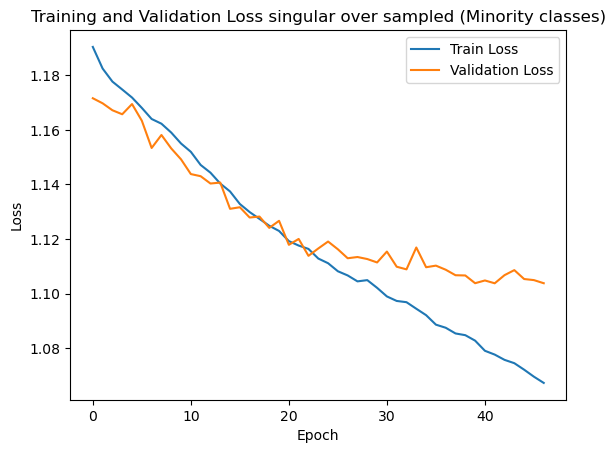

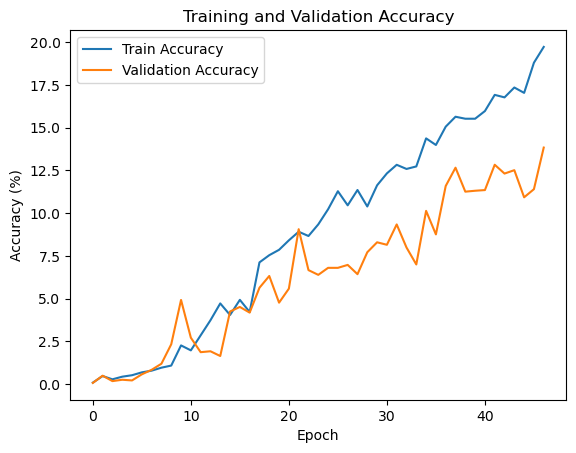

    Epoch  Train Loss  Train Accuracy  Val Loss  Val Accuracy
0       1    1.190387        0.082133  1.171580      0.066164
1       2    1.182460        0.468841  1.169722      0.489612
2       3    1.177675        0.277198  1.167174      0.172026
3       4    1.174777        0.431197  1.165706      0.251423
4       5    1.171832        0.516752  1.169450      0.211724
5       6    1.168036        0.684439  1.163341      0.569009
6       7    1.163977        0.783683  1.153349      0.833664
7       8    1.162248        0.958215  1.158115      1.190949
8       9    1.158996        1.081414  1.153180      2.328967
9      10    1.154983        2.262072  1.149178      4.922588
10     11    1.151942        1.971185  1.143786      2.712717
11     12    1.147129        2.850690  1.143005      1.865820
12     13    1.144298        3.733616  1.140322      1.918751
13     14    1.140312        4.719209  1.140663      1.640863
14     15    1.137414        4.041614  1.131050      4.247717
15     1

In [54]:
plt.plot(range(num_epochs_runned), train_losses, label="Train Loss")
plt.plot(range(num_epochs_runned), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss singular over sampled (Minority classes)')
plt.show()

# Plot training and validation accuracy
plt.plot(range(num_epochs_runned), train_accuracies, label="Train Accuracy")
plt.plot(range(num_epochs_runned), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Save the results in a DataFrame for reporting
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_runned + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies
})

print(results_df)